In [74]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
import matplotlib. pyplot as plt 
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor as rfr



In [246]:
#Load the training datasets
market = pd.read_csv('BTC-USD Training Data - 1st Jan 2016 to 1st Jan 2022.csv',  na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)

In [247]:
print("Dataframe Shape: ", market. shape)
print(market.head())

Dataframe Shape:  (2193, 6)
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2016-01-01  430.721008  436.246002  427.515015  434.334015  434.334015   
2016-01-02  434.622009  436.062012  431.869995  433.437988  433.437988   
2016-01-03  433.578003  433.743011  424.705994  430.010986  430.010986   
2016-01-04  430.061005  434.516998  429.084015  433.091003  433.091003   
2016-01-05  433.069000  434.182007  429.675995  431.959991  431.959991   

              Volume  
Date                  
2016-01-01  36278900  
2016-01-02  30096600  
2016-01-03  39633800  
2016-01-04  38477500  
2016-01-05  34522600  


# Visualization of Adj Close:-
The main advantage of adjusted closing prices is that they make it easier to evaluate stock performance. Firstly, the adjusted closing price helps investors understand how much they would have made by investing in a given asset. 

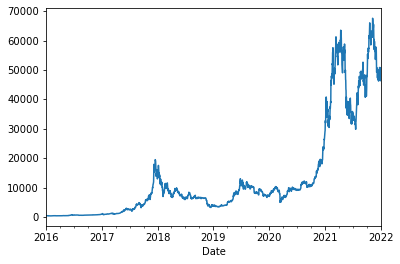

In [248]:
market['Adj Close'].plot()
xlabel='Date'

# Selection of Independent & Dependent Features
x-->Dependent Freatures & y-->Independent Feature

In [249]:
y = pd.DataFrame(market['Adj Close'])
x = ['Open', 'High', 'Low', 'Volume']

# Normalization
min-max scaling or min-max normalization, it is the simplest method and consists of rescaling the range of features to scale the range in [0, 1]

In [250]:
scaler = MinMaxScaler()
scale_down = scaler.fit_transform(market[x])
scale_down = pd.DataFrame(columns = x, data = scale_down, index = market.index)

scaler = MinMaxScaler()
y = scaler.fit_transform(y)
y = pd.DataFrame(data = y) 


scale_down, y 

(                Open      High       Low    Volume
 Date                                              
 2016-01-01  0.000977  0.000896  0.001100  0.000022
 2016-01-02  0.001035  0.000893  0.001166  0.000005
 2016-01-03  0.001020  0.000859  0.001057  0.000032
 2016-01-04  0.000967  0.000871  0.001123  0.000028
 2016-01-05  0.001012  0.000866  0.001132  0.000017
 ...              ...       ...       ...       ...
 2021-12-28  0.748903  0.735294  0.712726  0.095178
 2021-12-29  0.703416  0.697874  0.694360  0.085544
 2021-12-30  0.686549  0.694369  0.692221  0.075962
 2021-12-31  0.696652  0.703030  0.688581  0.105276
 2022-01-01  0.683886  0.693599  0.695677  0.069967
 
 [2193 rows x 4 columns],
              0
 0     0.001042
 1     0.001028
 2     0.000977
 3     0.001023
 4     0.001006
 ...        ...
 2188  0.702720
 2189  0.685694
 2190  0.696608
 2191  0.683637
 2192  0.704177
 
 [2193 rows x 1 columns])

# Time Series cross-validator or Time Series Split for Validation

*Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.
*This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.
*Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.Time Series cross-validator
*Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.
This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.
*Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.

In [251]:
ts = TimeSeriesSplit(n_splits = 10)    #10 KFold splits            
for train_ind, test_ind in ts.split(scale_down):
    xtr, xte = scale_down[:len(train_ind)], scale_down[len(train_ind):(len(train_ind)+len(test_ind))]
    ytr, yte = y[:len(train_ind)].values.ravel(), y[len(train_ind):(len(train_ind)+len(test_ind))].values.ravel()

In [252]:
print(scale_down.shape)

(2193, 4)


 xtr=training=[:len(train_ind)] it will split the training_scale_down values by considering all values upto the total values(training & testing values splits from scale_down.)
 
 xte=testing=len(train_ind):(len(train_ind)+len(test_ind) it is cosidering values from end of xtr upto the total number of values(i,e,,xtr+xte values)
 
 ytr, yte splits the values is also similar as explained above

# Reshape before using LSTM, because first we need to reshape into Tensor Format
LSTM shapes are (batch, steps, features)

-1 indicates that the reshape command should determine how many indices along this dimension are necessary to fit your array. 

In [253]:
trainx = np.array(xtr)       #Validation Training
testx = np.array(xte)        #Validation Testing
xtr = trainx.reshape(xtr.shape[0], 1, xtr.shape[1])   #xtr.shape[0]=rows/batch, steps=1, xtr.shape[1]=Column
xte= testx.reshape(xte.shape[0], 1, xte.shape[1])    #arr.shape[0] gives all rows/batch. & arr.shape[1] gives all columns/features.

# Creating Long Short-Term Memory (LSTM) RNN model
we use Sequential model it is a linear stack of layers.

We have 32 hidden layer because we have 32 number of rows & 1 dense layer.

input_shape=(timesteps, features), we need to convert to shape[1,32] in order to input.where trainx.shape[1] is 32.

In [254]:
from keras.models import Sequential
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainx.shape[1]), activation='relu',return_sequences=False))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')
print(lstm.summary())

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 32)                4736      
                                                                 
 dense_37 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________
None


# Model training with Validation datasets

In [255]:
log=lstm.fit(xtr, ytr, epochs=50, batch_size=8, verbose=1, shuffle=False)

Epoch 1/50
250/250 [==============================] - 7s 8ms/step - loss: 0.0045
Epoch 2/50
250/250 [==============================] - 2s 9ms/step - loss: 0.0077
Epoch 3/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0013
Epoch 4/50
250/250 [==============================] - 2s 8ms/step - loss: 4.9356e-04
Epoch 5/50
250/250 [==============================] - 2s 8ms/step - loss: 4.9173e-04
Epoch 6/50
250/250 [==============================] - 2s 9ms/step - loss: 4.6562e-04
Epoch 7/50
250/250 [==============================] - 3s 11ms/step - loss: 4.3904e-04
Epoch 8/50
250/250 [==============================] - 2s 7ms/step - loss: 3.8799e-04
Epoch 9/50
250/250 [==============================] - 3s 10ms/step - loss: 3.6031e-04
Epoch 10/50
250/250 [==============================] - 2s 8ms/step - loss: 3.3257e-04
Epoch 11/50
250/250 [==============================] - 2s 6ms/step - loss: 3.0395e-04
Epoch 12/50
250/250 [==============================] - 1s 5ms/step - loss

Epoch:-
An epoch is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed.

Batch_size:-
number of training examples utilized in one iteration.

# prediction of Validation test dataset

In [256]:
y_prediction= lstm.predict(xte)
xte

array([[[0.56525326, 0.5720808 , 0.5616593 , 0.10562551]],

       [[0.56165206, 0.552693  , 0.52858471, 0.10307298]],

       [[0.52823745, 0.52741385, 0.52369592, 0.08884372]],

       [[0.52390035, 0.52159181, 0.50096303, 0.10439272]],

       [[0.52506139, 0.51665364, 0.4686106 , 0.15039782]],

       [[0.46524465, 0.48114682, 0.43222686, 0.16793735]],

       [[0.4785414 , 0.50250126, 0.47583031, 0.1318991 ]],

       [[0.49591271, 0.50945066, 0.48510804, 0.09430361]],

       [[0.51044437, 0.51322755, 0.46944282, 0.11455649]],

       [[0.46483216, 0.47157482, 0.45177762, 0.1098676 ]],

       [[0.47514492, 0.50107932, 0.48036065, 0.10110898]],

       [[0.51074229, 0.50931968, 0.50808131, 0.09649531]],

       [[0.5077124 , 0.52864622, 0.51338837, 0.10791875]],

       [[0.52903911, 0.52181506, 0.51086923, 0.09696979]],

       [[0.51605397, 0.50663157, 0.49265897, 0.10774065]],

       [[0.49393013, 0.49060585, 0.49094602, 0.11027675]],

       [[0.49846718, 0.5047793 , 0.50051

# Visualizing the Actual Value v/s Predicted Value

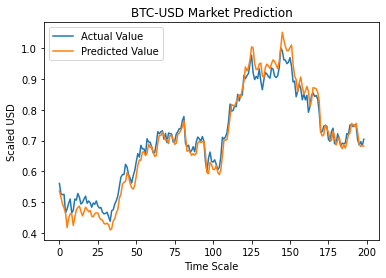

In [258]:
plt.plot(yte, label = 'Actual Value')
plt.plot(y_prediction, label = 'Predicted Value')
plt.title("BTC-USD Market Prediction")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# Analysing Testing Datasets or Out_of_Time_Testing Datasets without Training Datasets

In [259]:
oot = pd.read_csv('BTC-USD Out of Time Testing 1st Jan 2022 to 4th Feb 2022.csv',  na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)
x = ['Open', 'High', 'Low', 'Volume']
y = pd.DataFrame(oot['Adj Close'])


# Normalization of Out_of_Time_Testing Datasets

In [262]:
scaler = MinMaxScaler()
scale_down = scaler.fit_transform(oot[x])
scale_down = pd.DataFrame(columns = x, data = scale_down)

scaler = MinMaxScaler()
y = scaler.fit_transform(y)
y = pd.DataFrame(data = y)

scale_down, y

(        Open      High       Low    Volume
 0   0.891624  0.995275  0.958425  0.142900
 1   1.000000  1.000000  1.000000  0.191336
 2   0.973295  0.967621  0.925329  0.264950
 3   0.903268  0.958521  0.919222  0.400430
 4   0.858982  0.916811  0.703156  0.319289
 5   0.674248  0.639006  0.691989  0.223779
 6   0.641641  0.587020  0.577302  1.000000
 7   0.515619  0.506253  0.547669  0.192987
 8   0.529333  0.544251  0.596370  0.095622
 9   0.543225  0.503680  0.483622  0.251041
 10  0.536044  0.573706  0.601460  0.167988
 11  0.609077  0.672781  0.683465  0.271108
 12  0.704424  0.685276  0.677471  0.475142
 13  0.597734  0.603889  0.643504  0.128447
 14  0.637551  0.636906  0.693707  0.053596
 15  0.643103  0.611761  0.695316  0.046850
 16  0.638835  0.589275  0.621395  0.101323
 17  0.570125  0.532935  0.600324  0.111766
 18  0.579938  0.528035  0.589404  0.121461
 19  0.530069  0.609683  0.547709  0.082505
 20  0.447399  0.404191  0.190696  0.407868
 21  0.112734  0.022318  0.08521

# Reshaping the datasets before using into RNN

In [263]:
scale_down = np.array(scale_down)
scale_down = scale_down.reshape(scale_down.shape[0],1,scale_down.shape[1])
print(scale_down, y)


[[[0.89162366 0.99527487 0.95842477 0.1428998 ]]

 [[1.         1.         1.         0.19133624]]

 [[0.97329473 0.96762084 0.92532863 0.26494996]]

 [[0.90326768 0.95852066 0.91922165 0.40042997]]

 [[0.85898151 0.91681066 0.7031558  0.31928914]]

 [[0.67424764 0.63900649 0.6919889  0.2237788 ]]

 [[0.64164074 0.58701981 0.57730247 1.        ]]

 [[0.51561889 0.50625275 0.5476695  0.19298659]]

 [[0.52933328 0.54425102 0.5963705  0.09562248]]

 [[0.54322516 0.50367965 0.48362249 0.25104121]]

 [[0.53604408 0.57370632 0.60146041 0.1679883 ]]

 [[0.60907744 0.67278054 0.68346467 0.27110799]]

 [[0.70442364 0.68527648 0.6774714  0.4751421 ]]

 [[0.59773396 0.60388875 0.64350446 0.12844661]]

 [[0.6375507  0.63690598 0.69370735 0.05359649]]

 [[0.64310262 0.6117609  0.69531552 0.04684984]]

 [[0.63883479 0.58927523 0.62139523 0.10132345]]

 [[0.57012522 0.532935   0.60032392 0.11176591]]

 [[0.57993756 0.52803483 0.58940444 0.12146115]]

 [[0.53006948 0.60968324 0.5477095  0.08250515]]



In [264]:
y = np.array(y).reshape(-1)

# Out_of_Time Prediction

In [269]:
out_of_time_prediction = lstm.predict(scale_down)
print(out_of_time_prediction)

[[0.98759437]
 [1.0442935 ]
 [0.97869927]
 [0.93019414]
 [0.8152004 ]
 [0.64220524]
 [0.50931615]
 [0.48449323]
 [0.52825725]
 [0.46542424]
 [0.5385671 ]
 [0.6253196 ]
 [0.6442029 ]
 [0.5904553 ]
 [0.6429527 ]
 [0.6361228 ]
 [0.5926506 ]
 [0.53831303]
 [0.53498876]
 [0.53584605]
 [0.28778306]
 [0.03789825]
 [0.01247575]
 [0.0236799 ]
 [0.09777039]
 [0.1551317 ]
 [0.09081932]
 [0.13445032]
 [0.19840057]
 [0.19982842]
 [0.18630573]
 [0.247907  ]
 [0.21492831]
 [0.1112779 ]
 [0.1626878 ]]


# Visualization of Predicted Stock Market by using only Testing Datasets without Training the Model

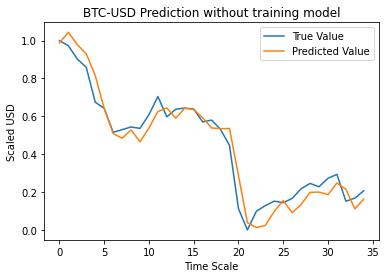

In [270]:
plt.plot(y, label = 'True Value')
plt.plot(out_of_time_prediction, label = 'Predicted Value')
plt.title("BTC-USD Prediction without training model")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# Finding the Accuracy of the Model of both Training & without Training Dataset using Ensemble Technique & r2 Score

In [273]:
y = np.array(y).reshape(-1)
out_of_time_prediction = np.array(out_of_time_prediction).reshape(-1)      #reshape(-1):-reshape with all the values
print(out_of_time_prediction)
print(y, '\n')

print('Accuracy of this code is ',r2_score(out_of_time_prediction, y))

[0.98759437 1.0442935  0.97869927 0.93019414 0.8152004  0.64220524
 0.50931615 0.48449323 0.52825725 0.46542424 0.5385671  0.6253196
 0.6442029  0.5904553  0.6429527  0.6361228  0.5926506  0.53831303
 0.53498876 0.53584605 0.28778306 0.03789825 0.01247575 0.0236799
 0.09777039 0.1551317  0.09081932 0.13445032 0.19840057 0.19982842
 0.18630573 0.247907   0.21492831 0.1112779  0.1626878 ]
[1.         0.97301054 0.9029203  0.85863158 0.67465032 0.64240821
 0.51575239 0.5296613  0.5436983  0.53656052 0.60882293 0.70468198
 0.5974229  0.63757037 0.64370941 0.63869071 0.57047882 0.5803616
 0.53048196 0.446422   0.11275308 0.         0.09849078 0.12831905
 0.15199656 0.14394675 0.16655268 0.21760111 0.24555875 0.22813079
 0.27281302 0.29336745 0.151916   0.16784586 0.20693501] 

Accuracy of this code is  0.9483397463432456


# Conclusion :-
The model gives 94.83% accuracy